## Setup

In [1]:
import pandas as pd
import numpy as np

import textstat
from scipy.stats import spearmanr, pearsonr, norm
from statsmodels.api import OLS
import statsmodels.api as sm

from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

sns.set_theme()
pd.set_option('display.max_colwidth', None)

data_dir = 'resources/data/'

packages = pd.read_csv(data_dir + 'packages.csv')
packages.dropna(inplace=True, subset=['headline'])
packages['click_rate'] = packages['clicks'] / packages['impressions']
packages.reset_index(inplace=True)

[nltk_data] Downloading package punkt to /home/zmjm/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/zmjm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/zmjm/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Pairwise t-statistics

The response of users depends on many factors, including the headline, the image, the time of day, the day of week, the user's mood, etc. The response is binary and stochastic, so we can model it as a Bernoulli random variable $X$ such that $X=1$ denotes that the user decides to click and $X=0$ is not to click.

To model the behavior of a group of users exposed to the same package, we can make the following assumptions:
- Each user make choice of whether to click on a headline independently
- The probability of clicking on a headline is the same for all users

The first assumption is reasonable because the users are typically independent of each other. The second assumption is not very realistic since each user should have his/her own preferences, but it is a good approximation if the number of users for the package is large.

Then the number of clicks $Y = X_1 + X_2 + ... + X_n $ out of $n$ users is a binomial random variable with parameters $n$ and $p$, where $p$ is the probability of clicking on a headline.
In practice, since the click rate is usually small, we can use a Poisson distribution to approximate the binomial distribution, therefore the variance of $Y$ is $np$ which is the same as the expected value.

From the observed $Y$, we can estimate the click rate $p$ as $\hat{p} = Y/n$ and the variance of the estimate is $\hat{p}/n$.
The t-statistic of the difference in click rate between two packages is then
$$ t = \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{\hat{p}_1/n_1 + \hat{p}_2/n_2}} $$
where $n_1$ and $n_2$ are the number of users exposed to the two packages respectively.

Since the number of packages within a test could be more than 2, we define the pairwise t-statistic of a test as the t-statistic of the difference in click rate between two packages within the test. Then we can perform a t-test on the pairwise t-statistics to determine whether the difference in click rate between two packages is statistically significant.

Additionally, since we want to study the effect of headline, we can look into the pair of packages that are different only by their headlines.

In [2]:
tests = packages.groupby('test_id', group_keys=False)
t_stat = pd.DataFrame(columns=['test_id', 'A_package_id', 'B_package_id', 'A_headline', 'B_headline', 't', 'A_click_rate', 'B_click_rate', 'A_impressions', 'B_impressions'])

for test_id, test in tqdm(tests):
    if len(test) >= 2:
        num_packages = len(test)
        
        for i in range(num_packages - 1):
            for j in range(i + 1, num_packages):

                test_a, test_b = test.iloc[i], test.iloc[j]
                
                if test_a.click_rate == 0 and test_b.click_rate == 0:
                    continue

                if test_a.headline == test_b.headline:
                    continue

                if test_a.image_id != test_b.image_id:
                    continue
                
                t = (test_a.click_rate - test_b.click_rate) / np.sqrt(
                    test_a.click_rate/test_a.impressions + test_b.click_rate/test_b.impressions)
                
                if t > 0:
                    t_stat.loc[len(t_stat)] = [test_id, test.index[i], test.index[j], test_a.headline.lower(), test_b.headline.lower(), 
                                               t, test_a.click_rate, test_b.click_rate, test_a.impressions, test_b.impressions]
                else:
                    t_stat.loc[len(t_stat)] = [test_id, test.index[j], test.index[i], test_b.headline.lower(), test_a.headline.lower(), 
                                               t, test_b.click_rate, test_a.click_rate, test_b.impressions, test_a.impressions]

100%|██████████| 32487/32487 [10:23<00:00, 52.11it/s] 


In [3]:
t_stat.t.describe()

count    140621.000000
mean          0.168743
std           1.967454
min         -13.314745
25%          -1.053958
50%           0.185051
75%           1.387549
max          14.248627
Name: t, dtype: float64

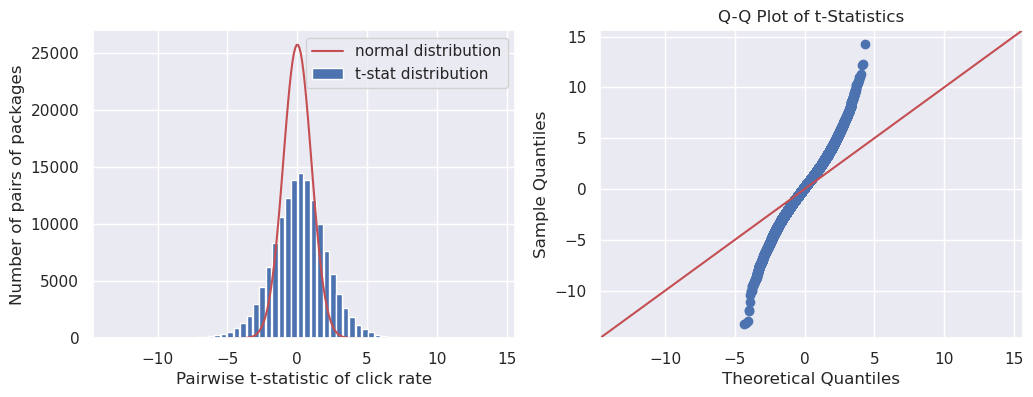

In [4]:
count, binedge = np.histogram(t_stat.t, bins=60)
bincenter = (binedge[:-1] + binedge[1:]) / 2

excess = count / norm.pdf(bincenter)

plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.bar(bincenter, count, width=0.4, label='t-stat distribution')
plt.plot(np.linspace(-5, 5, 100), norm.pdf(np.linspace(-5, 5, 100), 0, 1) * len(t_stat) * (binedge[1] - binedge[0]), 'r', label='normal distribution')
plt.legend()
plt.xlabel('Pairwise t-statistic of click rate')
plt.ylabel('Number of pairs of packages')

sm.qqplot(t_stat.t, line='45', ax=plt.subplot(122))
plt.title('Q-Q Plot of t-Statistics')
plt.show()

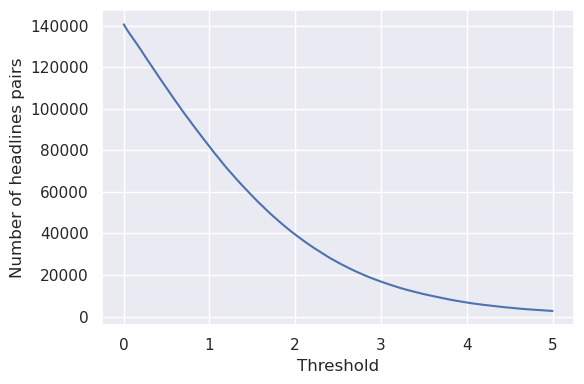

In [5]:
thresholds = np.linspace(0, 5, 100)
size = []

for threshold in thresholds:
    size.append(sum(abs(t_stat.t) > threshold))

plt.figure(figsize=(6, 4))
plt.plot(thresholds, size)
plt.xlabel('Threshold')
plt.ylabel('Number of headlines pairs')
plt.tight_layout()
plt.show()

In [6]:
sum(abs(t_stat.t) > 5) / len(t_stat)

0.019207657462256705

In [7]:
t_stat.sort_values('t', key=abs, ascending=False).head(1000).sample(20)[['A_headline', 'B_headline', 't']]

,A_headline,B_headline,t
18975,a straight guy finally gets what it's like to be gay,ever have someone defriend you over something they didn't like on your facebook page?,7.263344
4112,here’s a very important story that the mainstream media isn’t really covering,meet the folks who are fighting the biggest school closing in american history\n,-6.230885
8456,cookie monster is in jail? i'm actually really happy about the reason why.,watch kids facing scary problems get help from an unexpected crew of furry friends,6.078326
41052,this guy was really nice to a homeless little girl and got the best reward ever in return,he doesn't do such wonderful things for money or recognition. and he gets a lot more in return.,-6.225383
48913,she's already beautiful in the beginning. she ends as the reason why we have toxic beauty ideals.,a piece about accepting our real values beyond beautifying and photoshopping,9.457987
17209,this man kept a secret for most of his life. not the kind of secret you're probably thinking...,can you really define what an american is?,-7.175026
61443,"these 2 minutes all have only lego folk still, motionless. by the end i'm moved to a pulsing rage.","if it's an art, shell might be considered the picasso of pollution. and no one could ever hide that.",-6.490623
45156,"the adorable, slightly rude tale of how a 90-year-old mom found out her son was gay",that one time i had to put heartwarming and crude in the same headline about marriage equality,6.392766
30120,"a straight guy says ""i'd be offended by you if i were gay."" just listen to this actor's response.","he may be a character in science fiction, but the discrimination he's fighting here is so very real",7.435279
11936,"what these kids did to those dogs ... eh, just watch. you'll love it.","magicians, take note: follow these kids' example and start making something wonderful appear.",6.851196


## Language complexity measure

- Type-token ratio: https://en.wikipedia.org/wiki/Lexical_diversity#Type%E2%80%93token_ratio
- Flesch-Kincaid Grade Level: https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests#Flesch%E2%80%93Kincaid_grade_level
- Word complexity: https://en.wikipedia.org/wiki/Lexical_density

### Type-token ratio

In [8]:
def get_TTR(texts, random_state=0, curve=True, num_tokens=None):
    texts = texts.sample(frac=1, random_state=random_state)
    vocab = dict()
    tokens = 0
    ttr = []

    for text in tqdm(texts):
        words = word_tokenize(text)
        for word in words:
            if word not in vocab:
                vocab[word] = 1
            else:
                vocab[word] += 1
            tokens += 1
            ttr.append(len(vocab) / tokens)
            
            if num_tokens is not None and tokens >= num_tokens:
                if not curve:
                    return ttr[-1], vocab, tokens
                else:
                    return ttr, vocab, tokens
    if not curve:        
        return ttr[-1], vocab, tokens
    else:
        return ttr, vocab, tokens

def split_headlines(t_stat, threshold):
    good_headlines = t_stat.A_headline[abs(t_stat.t) > threshold]
    bad_headlines = t_stat.B_headline[abs(t_stat.t) > threshold]

    good_headlines = good_headlines.sample(frac=1, random_state=0)
    bad_headlines = bad_headlines.sample(frac=1, random_state=0)

    mixed_headlines = pd.concat([good_headlines, bad_headlines], ignore_index=True).sample(frac=1, random_state=0)

    good_headlines_unique = pd.Series(good_headlines.unique())
    bad_headlines_unique = pd.Series(bad_headlines.unique())

    print('good_headlines: {}, bad_headlines: {}, good_headlines_unique: {}, bad_headlines_unique: {}'.format(
        good_headlines.shape[0], bad_headlines.shape[0], good_headlines_unique.shape[0], bad_headlines_unique.shape[0]))
    
    return {'good': good_headlines, 'bad': bad_headlines, 'good_unique': good_headlines_unique, 'bad_unique': bad_headlines_unique, 'mixed': mixed_headlines}

In [9]:
thresholds = [0, 1, 2, 3, 4, 5]
# threshold = [5]

num_tokens = 2e4
num_samples = 10

ttr_record = dict()
vocab_record = dict()

ttr = dict()

for i, threshold in enumerate(thresholds):
    corpus = split_headlines(t_stat, threshold=threshold)
    ttr[threshold] = dict()
    ttr_record[threshold] = dict()
    vocab_record[threshold] = dict()

    for text in ['good', 'bad', 'good_unique', 'bad_unique', 'mixed']:
        ttr[threshold][text], _, _ = get_TTR(corpus[text])

        new_record = []
        for j in range(num_samples):
            new_record.append(get_TTR(corpus[text], random_state=j, curve=False, num_tokens=num_tokens)[0])
        ttr_record[threshold][text] = new_record
        vocab_record[threshold][text] = get_TTR(corpus[text], curve=False, num_tokens=num_tokens)[1]

ttr_record = pd.DataFrame(ttr_record).T
vocab_record = pd.DataFrame(vocab_record).T

good_headlines: 140594, bad_headlines: 140594, good_headlines_unique: 48715, bad_headlines_unique: 53683


  0%|          | 0/140594 [00:00<?, ?it/s]

  0%|          | 1147/281188 [00:00<00:19, 14345.72it/s]


good_headlines: 81791, bad_headlines: 81791, good_headlines_unique: 34402, bad_headlines_unique: 39827


  1%|          | 1165/163582 [00:00<00:10, 15151.61it/s]


good_headlines: 39455, bad_headlines: 39455, good_headlines_unique: 19741, bad_headlines_unique: 23482


  1%|▏         | 1169/78910 [00:00<00:05, 13692.29it/s]


good_headlines: 16808, bad_headlines: 16808, good_headlines_unique: 9595, bad_headlines_unique: 11532


  3%|▎         | 1163/33616 [00:00<00:02, 15909.85it/s]


good_headlines: 6757, bad_headlines: 6757, good_headlines_unique: 4214, bad_headlines_unique: 5103


  8%|▊         | 1142/13514 [00:00<00:00, 14944.04it/s]


good_headlines: 2701, bad_headlines: 2701, good_headlines_unique: 1812, bad_headlines_unique: 2178


 22%|██▏       | 1163/5402 [00:00<00:00, 15156.99it/s]


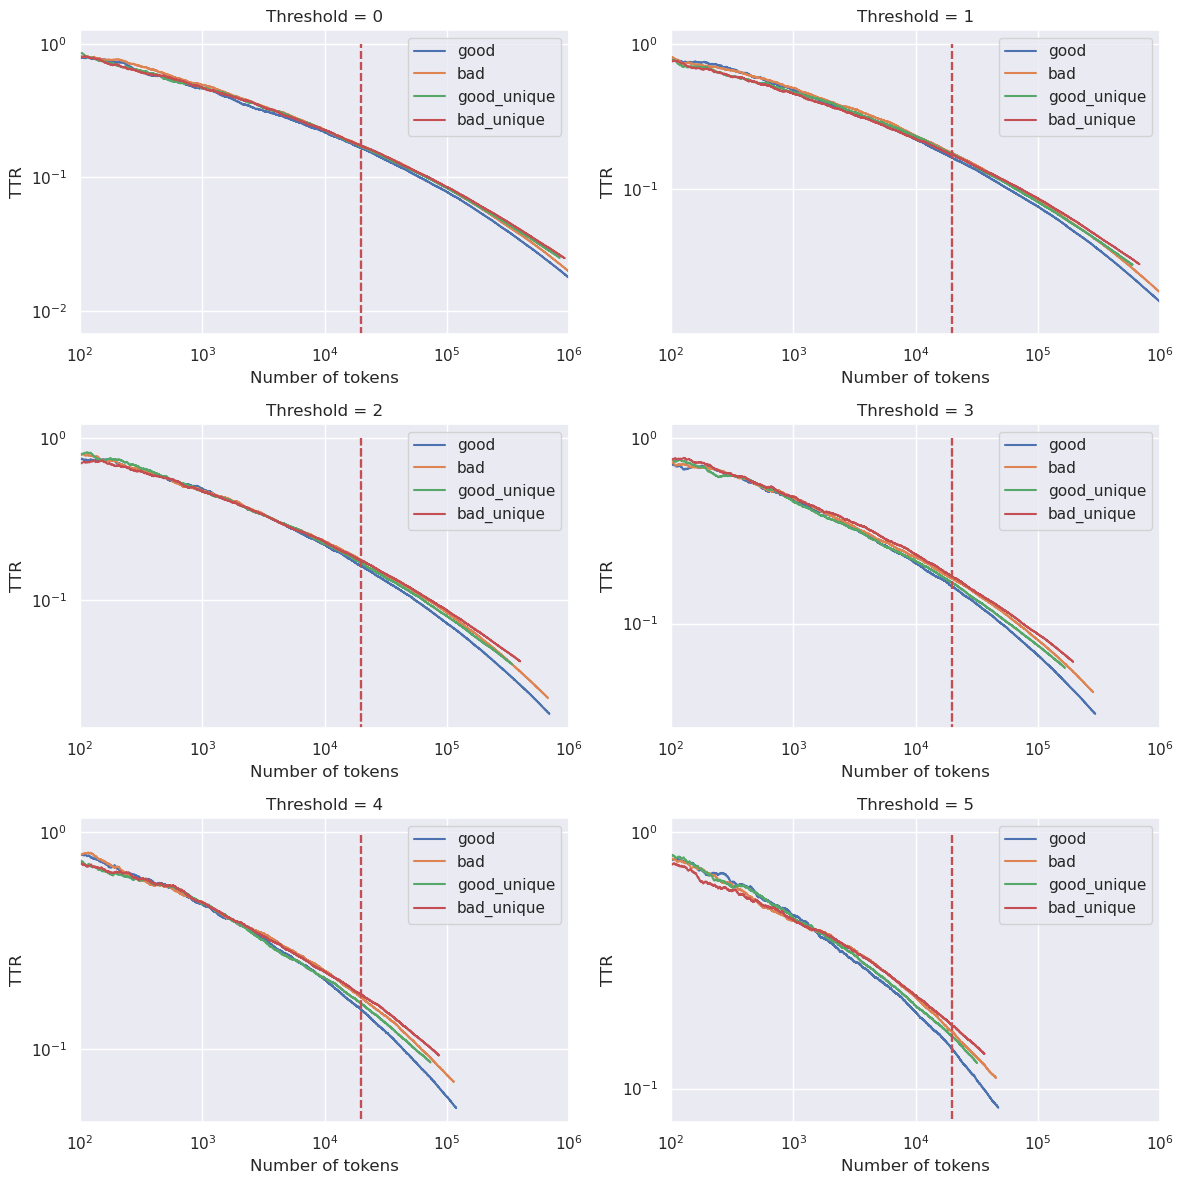

In [10]:
plt.figure(figsize=(12, 12))

for i, threshold in enumerate(thresholds):
    plt.subplot(3, 2, i + 1)
    plt.plot(ttr[threshold]['good'], label='good')
    plt.vlines(2e4, 0, 1, linestyles='dashed', colors='r')
    plt.plot(ttr[threshold]['bad'], label='bad')
    plt.vlines(2e4, 0, 1, linestyles='dashed', colors='r')
    plt.plot(ttr[threshold]['good_unique'], label='good_unique')
    plt.vlines(2e4, 0, 1, linestyles='dashed', colors='r')
    plt.plot(ttr[threshold]['bad_unique'], label='bad_unique')
    plt.vlines(2e4, 0, 1, linestyles='dashed', colors='r')
    plt.xlim(1e2, 1e6)
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.xlabel('Number of tokens')
    plt.ylabel('TTR')
    plt.title('Threshold = {}'.format(threshold))

plt.tight_layout()
plt.show()

In [11]:
ttr_record_mean = ttr_record.apply(lambda x: x.apply(np.mean))
ttr_record_mean

,good,bad,good_unique,bad_unique,mixed
0,0.166185,0.173495,0.171730,0.174830,0.171040
1,0.164570,0.174945,0.169380,0.176455,0.169520
2,0.159955,0.175825,0.167220,0.177335,0.169295
3,0.155355,0.174790,0.164140,0.177815,0.169290
4,0.150355,0.172430,0.161205,0.178340,0.164630
5,0.139585,0.165040,0.155885,0.176645,0.158945


In [12]:
ttr_record_std = ttr_record.apply(lambda x: x.apply(np.std))
ttr_record_std

,good,bad,good_unique,bad_unique,mixed
0,0.001100,0.001473,0.001886,0.002309,0.001986
1,0.001095,0.002265,0.002190,0.002540,0.002367
2,0.001185,0.002960,0.001162,0.001928,0.001746
3,0.001496,0.001412,0.001484,0.000914,0.002593
4,0.001767,0.001234,0.002065,0.001164,0.001479
5,0.002137,0.001586,0.001660,0.000891,0.002349


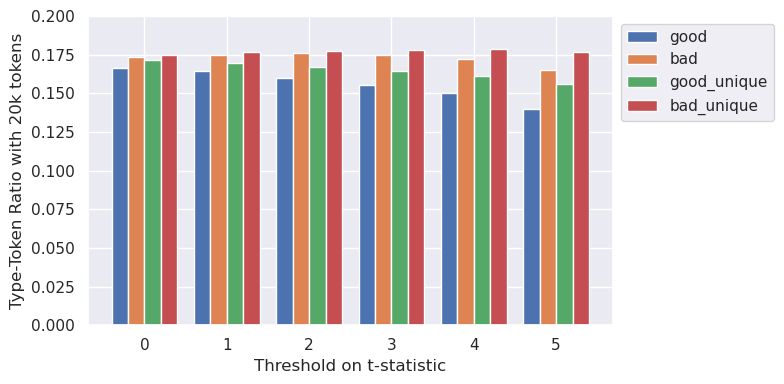

In [13]:
plt.figure(figsize=(8, 4))

indices = np.arange(len(ttr_record_mean['good']))

plt.bar(indices - 0.3, ttr_record_mean['good'], width=0.2, label='good')
plt.bar(indices - 0.1, ttr_record_mean['bad'], width=0.2, label='bad')
plt.bar(indices + 0.1, ttr_record_mean['good_unique'], width=0.2, label='good_unique')
plt.bar(indices + 0.3, ttr_record_mean['bad_unique'], width=0.2, label='bad_unique')
# plt.bar(indices + 0.5, ttr_record['mixed'], width=0.2, label='mixed')

# move the legend to the upper left corner
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Threshold on t-statistic')
plt.ylabel('Type-Token Ratio with 20k tokens')
plt.ylim(0, 0.2)
plt.tight_layout()
plt.show()

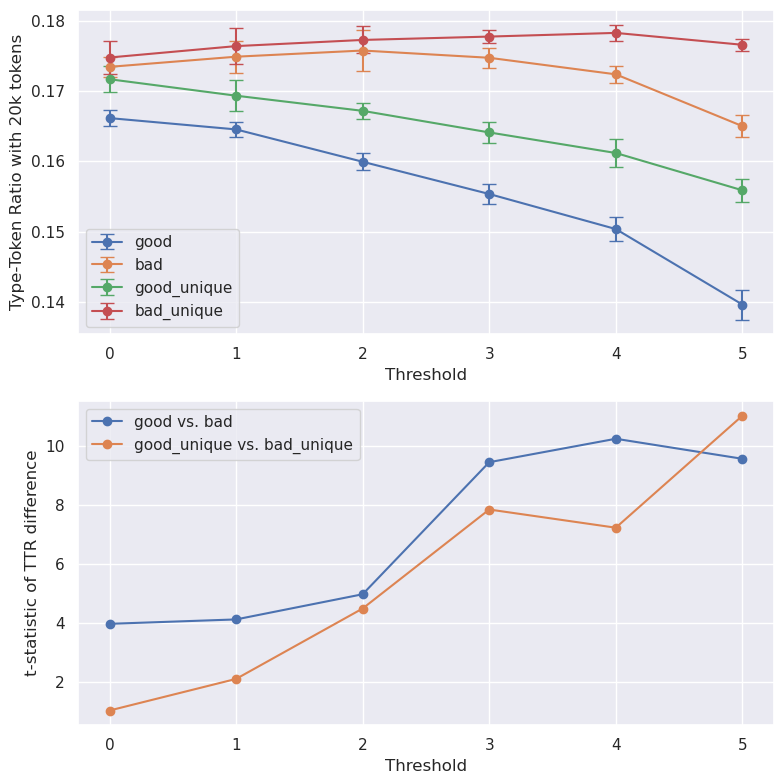

In [14]:
good_bad = abs(ttr_record_mean['good'] - ttr_record_mean['bad']) / (ttr_record_std['good']**2 + ttr_record_std['bad']**2)**0.5
good_bad_unique = abs(ttr_record_mean['good_unique'] - ttr_record_mean['bad_unique']) / (ttr_record_std['good_unique']**2 + ttr_record_std['bad_unique']**2)**0.5

plt.figure(figsize=(8, 8))

plt.subplot(211)
plt.errorbar(indices, ttr_record_mean['good'], ttr_record_std['good'], fmt='o-', capsize=5, label='good')
plt.errorbar(indices, ttr_record_mean['bad'], ttr_record_std['bad'], fmt='o-', capsize=5, label='bad')
plt.errorbar(indices, ttr_record_mean['good_unique'], ttr_record_std['good_unique'], fmt='o-', capsize=5, label='good_unique')
plt.errorbar(indices, ttr_record_mean['bad_unique'], ttr_record_std['bad_unique'], fmt='o-', capsize=5, label='bad_unique')
# plt.errorbar(indices + 0.5, ttr_record_mean['mixed'], ttr_record_std['mixed'], fmt='o', label='mixed')

# move the legend to the lower left corner
plt.legend(loc='lower left', bbox_to_anchor=(0, 0))
plt.xlabel('Threshold')
plt.ylabel('Type-Token Ratio with 20k tokens')

plt.subplot(212)
plt.plot(indices, good_bad, 'o-', label='good vs. bad')
plt.plot(indices, good_bad_unique, 'o-', label='good_unique vs. bad_unique')
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('t-statistic of TTR difference')

plt.tight_layout()
plt.show()

In [15]:
ttr_record_mean * 2e4

,good,bad,good_unique,bad_unique,mixed
0,3323.7,3469.9,3434.6,3496.6,3420.8
1,3291.4,3498.9,3387.6,3529.1,3390.4
2,3199.1,3516.5,3344.4,3546.7,3385.9
3,3107.1,3495.8,3282.8,3556.3,3385.8
4,3007.1,3448.6,3224.1,3566.8,3292.6
5,2791.7,3300.8,3117.7,3532.9,3178.9


### Readibility tests

In [30]:
headlines = pd.Series(pd.concat([t_stat.A_headline, t_stat.B_headline]).unique())
headlines

0                               here's the science, here's the gay. open your brain, they were born that way!
1                                 hey dude. if you have an older brother, there's a bigger chance you're gay.
2        if you know anyone who is afraid of gay people, here's a cartoon that will ease them back to reality
3            i've got some news for you. being gay is genetic. being irrationally afraid of gay, not so much.
4                                                how you can help new york stay un-fracked in under 5 minutes
                                                         ...                                                 
63204              francis comes out against the gender pay gap, one again claiming the title of 'cool pope.'
63205                         what if there was a very simple way to prevent most heroin overdoses? there is.
63206                       feel like something is holding you back? maybe there's another way to look at it.
63207     

In [36]:
t_stat['click_rate_ratio'] = t_stat.A_click_rate.div(t_stat.B_click_rate, fill_value=np.nan)

tqdm.pandas()
t_stat['A_grade_level'] = t_stat.A_headline.progress_apply(textstat.flesch_kincaid_grade)

tqdm.pandas()
t_stat['B_grade_level'] = t_stat.B_headline.progress_apply(textstat.flesch_kincaid_grade)

tqdm.pandas()
t_stat['A_reading_ease'] = t_stat.A_headline.progress_apply(textstat.flesch_reading_ease)

tqdm.pandas()
t_stat['B_reading_ease'] = t_stat.B_headline.progress_apply(textstat.flesch_reading_ease)

100%|██████████| 140621/140621 [00:00<00:00, 168586.82it/s]


In [ ]:
click_ratio_stat = pd.DataFrame(index=t_stat.test_id.unique(), columns='click_rate_ratio')
